# LIBRARIES

In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
import torch_geometric.utils as pyg_utils
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import to_dense_adj,dense_to_sparse

import networkx as nx
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score
import matplotlib.pyplot as plt

from typing import Optional,Tuple

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DATASET

In [2]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.to_device.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.25, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])
dataset = Planetoid(root='/train/Cora', name='Cora',transform=transform)
train_data, val_data, test_data = dataset[0]
{
    'graph number': len(dataset),
    'num_classes': dataset.num_classes,
    'num_node_features': dataset.num_node_features,
    'graph' : dataset[0],
}

{'graph number': 1,
 'num_classes': 7,
 'num_node_features': 1433,
 'graph': (Data(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[3696], pos_edge_label_index=[2, 3696]),
  Data(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[263], pos_edge_label_index=[2, 263], neg_edge_label=[263], neg_edge_label_index=[2, 263]),
  Data(x=[2708, 1433], edge_index=[2, 7918], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[1319], pos_edge_label_index=[2, 1319], neg_edge_label=[1319], neg_edge_label_index=[2, 1319]))}

# MODEL

In [3]:
class GCN_Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_Encoder, self).__init__()
        self.gcn_shared = pyg_nn.GCNConv(in_channels, hidden_channels)
        self.gcn_mu = pyg_nn.GCNConv(hidden_channels, out_channels)
        self.gcn_logvar = pyg_nn.GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.gcn_shared(x, edge_index))
        mu = self.gcn_mu(x, edge_index)
        logvar = self.gcn_logvar(x, edge_index)
        return mu, logvar

in_channels = train_data.num_node_features
hidden_channels = in_channels * 3
latent_dim = 32
model = pyg_nn.VGAE(GCN_Encoder(in_channels,hidden_channels,latent_dim))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

hist = {'train':{},'test':{}}
metrics = "loss auc ap"
for mode in "train test".split():
    for m in metrics.split():
        hist[mode][m]=[]

In [4]:
def plot_loss(hist):
    import matplotlib.pyplot as plt
    fig,axs = plt.subplots(1,3,figsize=(12,4))
    epoch = len(hist['train']['loss'])
    fig.suptitle(f'epoch - {epoch}')
    
    for ax,m in zip(axs.flatten(),hist['train'].keys()):
        ax.set_title(m)
        ax.plot(hist['train'][m],label='train')
        ax.plot(hist['test'][m],label='test')
        ax.legend()
    
    plt.show()

In [5]:
def recon_loss(self, z: Tensor, pos_edge_index: Tensor,
                   neg_edge_index: Optional[Tensor] = None) -> Tensor:
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to train against.
            neg_edge_index (torch.Tensor, optional): The negative edges to
                train against. If not given, uses negative sampling to
                calculate negative edges. (default: :obj:`None`)
        """
        from torch_geometric.utils import negative_sampling
        EPS = 1e-15
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + EPS).mean()
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).mean()
        total =  pos_loss +  neg_loss
        return total

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    auc,ap = model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)
    # loss = model.recon_loss(z, data.pos_edge_label_index, data.neg_edge_label_index)
    loss = recon_loss(model,z,data.pos_edge_label_index)
    loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    return loss.item(),auc,ap

# Training loop
def train(data):
    model.train()
    z = model.encode(data.x, data.edge_index)
    # loss = model.recon_loss(z, data.pos_edge_label_index)
    loss = recon_loss(model,z,data.pos_edge_label_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

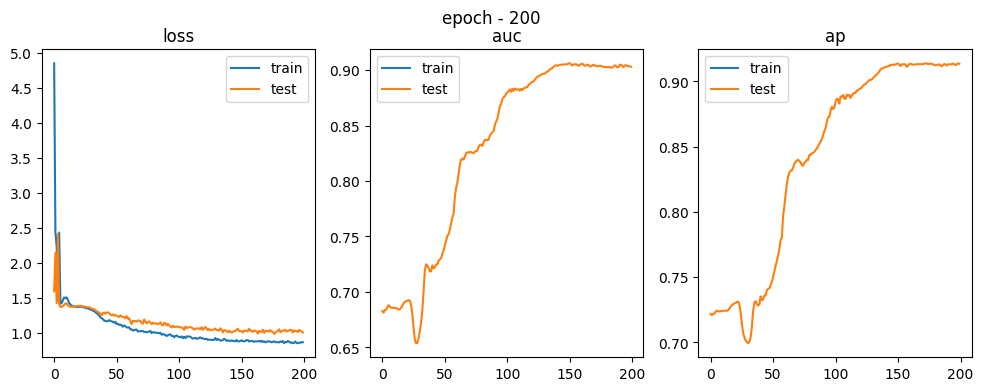

In [6]:
for epoch in range(200):
    loss = train(train_data)
    hist['train']['loss'].append(loss)
    
    
    # ap - Average Precision
    loss,auc,ap = test(test_data)
    hist['test']['loss'].append(loss)
    hist['test']['auc'].append(auc)
    hist['test']['ap'].append(ap)
    
plot_loss(hist)

# Observation

1. precision = true positive / all predicted positive
2. recall =  true positive / all positive

In words, precision tells us how many are true positive among all predicted positive whereas recall how many positive is captured among all positive. High precision but low recall implies that the model is very conservative such that it will make sure all predictions are right but not capturing all; underestimating link presence.

In [7]:
def fn(threshold):
    model.eval()
    z = model.encode(val_data.x, val_data.edge_index)
    adj = model.decoder.forward_all(z)
    adj = adj > threshold
    fn = lambda t : t.flatten().cpu().long()
    pred,target = fn(adj), fn(to_dense_adj(val_data.edge_index))
    
    cm = confusion_matrix(target,pred)
    
    tn,fn, fp, tp = cm.flatten()
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    acc = (tn+tp) / sum([tn,fn, fp, tp])
    f1 = (precision * recall)/(precision + recall)
    
    return precision,recall,acc,f1
fn(0.9)

(0.8422619047619048,
 0.04996188259840308,
 0.9836968913160633,
 0.047164165536676086)

0.95

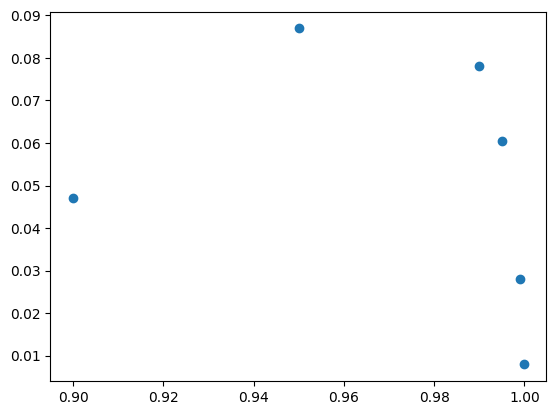

In [8]:
x = [0.9,0.95,0.99,0.995,0.999,0.9999]
y = []
for t in x:
    *_,f1 = fn(t)
    y.append(f1)

plt.scatter(x,y)

i = torch.tensor(y).argmax().item()
threshold = x[i]
threshold

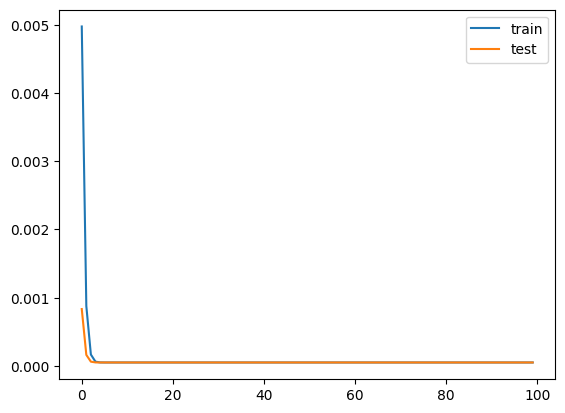

In [9]:
class VGAE_Node_Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(VGAE_Node_Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU(),
        )

    def forward(self, z):
        x = self.fc(z)
        return x

def test(encoder,decoder,data):
    model.eval()
    z= encoder.encode(data.x, data.edge_index)
    x = decoder(z)
    loss = F.mse_loss(x,data.x)
    return loss.item()

# Training loop
def train(encoder,decoder,data,optimizer,):
    model.train()
    z = encoder.encode(data.x, data.edge_index)
    x = decoder(z)
    loss = F.mse_loss(x,data.x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

node_model = VGAE_Node_Decoder(latent_dim,latent_dim*3,train_data.num_node_features)
node_model = node_model.to(device)
optimizer = torch.optim.Adam(node_model.parameters(),lr=0.01)
train_hist = []
test_hist = []

for i in range(100):
    loss = train(model,node_model,train_data,optimizer)
    train_hist.append(loss)
    loss = test(model,node_model,test_data)
    test_hist.append(loss)

plt.plot(train_hist,label='train')
plt.plot(test_hist,label='test')
plt.legend()

In [28]:
def reconstruct_data(model,decoder,data):
    z = model.encode(data.x, data.edge_index)
    x = decoder(z).detach()
    adj = model.decoder.forward_all(z).detach()
    adj = adj > threshold
    return Data(x=x,edge_index=dense_to_sparse(adj)[0],y=data.y,
                train_mask = data.train_mask,
                val_mask = data.val_mask,
                test_mask = data.test_mask)

In [29]:
dataset = Planetoid(root='/data/Cora', name='Cora')
data = dataset[0].to(device)
{
    'graph number': len(dataset),
    'num_classes': dataset.num_classes,
    'num_node_features': dataset.num_node_features
}

{'graph number': 1, 'num_classes': 7, 'num_node_features': 1433}

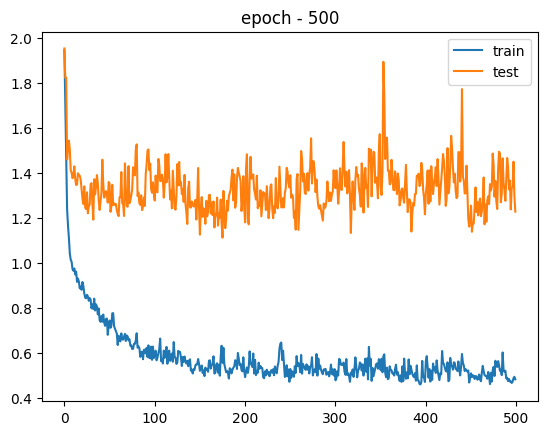

Accuracy: 0.6500


In [30]:
class GCN(nn.Module):
    def __init__(self,seed=42):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = pyg_nn.GCNConv(dataset.num_node_features, 16)
        self.conv2 = pyg_nn.GCNConv(16, dataset.num_classes)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x,edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

def plot_loss(hist):
    import matplotlib.pyplot as plt
    plt.title(f'epoch - {len(hist["train"])}')
    plt.plot(hist['train'],label='train')
    plt.plot(hist['test'],label='test')
    plt.legend()
    plt.show()

def test(model,data):
    out = model(data)
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc
    
def train(model,dataset,optimizer, hist = {'train':[],'test':[]}, n = 100):
    for epoch in range(n):
        train_losses = []
        test_losses = []
        for data in dataset:
            model.train()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        
            model.eval()
            loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
            test_losses.append(loss.item())
        
        mean = lambda xs : torch.tensor(xs).mean()   
        hist['train'].append(mean(train_losses))
        hist['test'].append(mean(test_losses))
    
    plot_loss(hist)
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    print(f'Accuracy: {acc:.4f}')

classifier_model = GCN().to(device)
optimizer = torch.optim.Adam(classifier_model.parameters(), lr=0.1, weight_decay=5e-4)
train(classifier_model,[data,reconstruct_data(model,node_model,data)], optimizer,n=500)

In [33]:
test(classifier_model,reconstruct_data(model,node_model,data))

0.65

In [34]:
test(classifier_model,data)

0.771